In [1]:
import autograd.numpy as np
from autograd import grad
from autograd import elementwise_grad
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve, cholesky

In [2]:
#build toy dataset
def generate_samples(n_samples_class):
    cov = np.array([[10, 2], [2, 1]])
    mean1 = np.array([0, 0])
    mean2 = np.array([0, 5])

    total_n_samples = n_samples_class*2
    x =  np.zeros((total_n_samples, 2))

    x[:n_samples_class, 0], x[:n_samples_class, 1] = np.random.multivariate_normal(mean1, cov, n_samples_class).T
    x[n_samples_class:, 0], x[n_samples_class:, 1]  = np.random.multivariate_normal(mean2, cov, n_samples_class).T

    labels = np.zeros(total_n_samples)
    labels[n_samples_class:] = 1
    return x, labels

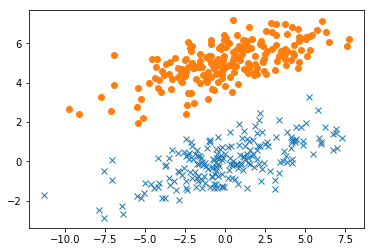

In [3]:
n_samples_class = 200
x, y  =  generate_samples(n_samples_class)
plt.plot(x[:n_samples_class,0], x[:n_samples_class,1], 'x')
plt.plot(x[n_samples_class:,0], x[n_samples_class:,1], 'o')
#plt.savefig("data_2d.png")
plt.show()

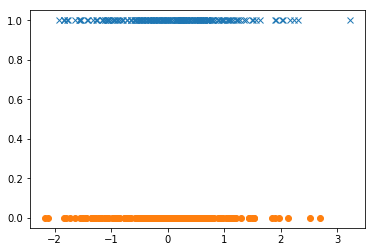

In [4]:
from sklearn.decomposition import FactorAnalysis
transformer = FactorAnalysis(n_components=1, random_state=0)
x_proj_fa_python = transformer.fit_transform(x)
plt.plot(x_proj_fa_python[:n_samples_class,0], np.ones(n_samples_class), 'x')
plt.plot(x_proj_fa_python[n_samples_class:,0], np.zeros(n_samples_class), 'o')
#plt.savefig('data_proj_fa_python')
plt.show()

In [5]:
transformer.loglike_

[-2658.4024828358392,
 -1995.1416360877474,
 -1984.942872780438,
 -1984.9042987588507,
 -1984.9042058360094]

In [9]:
def compute_ll(f, bias, cov_noise, x):
    N = x.shape[0]
    D = x.shape[1]
    f =  f.reshape(D, 1)
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    temp1 = np.linalg.solve(cov_x, (x - bias).T)
    ll = N*D*np.log(2*np.pi)/2

    ll += log_det_cov_x*N/2
    
    ll += np.sum(np.einsum("nd,dn->n", x - bias, temp1))/2
    
    return -ll

print compute_ll(transformer.components_.T, np.mean(x, axis = 0), np.diag(transformer.noise_variance_), x)


-1984.904205836429


In [26]:
def objective_ll_var(var, f, bias, x):
    N = x.shape[0]
    D = x.shape[1]
    cov_noise = np.diag(np.log(np.exp(var)+1))
    
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    
    temp1 = np.linalg.solve(cov_x, (x - bias).T)
    unnorm_log_pdf_x = np.einsum("nd,dn->n", x - bias, temp1)

    ll = N*D*np.log(2*np.pi)/2 + log_det_cov_x*N/2 + np.sum(unnorm_log_pdf_x)/2
    return ll 

def objective_ll_f(f, var, bias, x):
    N = x.shape[0]
    D = x.shape[1]
    f =  f.reshape(D, 1)
    cov_noise = np.diag(var)
    
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    
    temp1 = np.linalg.solve(cov_x, (x - bias).T)
    unnorm_log_pdf_x = np.einsum("nd,dn->n", x - bias, temp1)

    ll = N*D*np.log(2*np.pi)/2 + log_det_cov_x*N/2 + np.sum(unnorm_log_pdf_x)/2
    
    return ll 

def objective_ll_all(params, x, y):
    N = x.shape[0]
    D = x.shape[1]
    f, bias, cov_noise, w = decode_parameters(params, D, latent_dim)
        
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    
    temp1 = np.linalg.solve(cov_x, (x - bias).T)
    unnorm_log_pdf_x = np.einsum("nd,dn->n", x - bias, temp1)

    ll = N*D*np.log(2*np.pi)/2 + log_det_cov_x*N/2 + np.sum(unnorm_log_pdf_x)/2
    
    return ll 

def decode_parameters(params, D, latent_dim):
    size_f = D*latent_dim
    f =  params[:size_f]
    f =  f.reshape(D, latent_dim)
    bias = params[size_f:size_f+D]
    var = params[size_f+D:size_f+D*2]
    cov_noise= np.diag(np.log(1+np.exp(var)))
    w = params[size_f+D*2:]
    
    return f, bias, cov_noise, w

def transform(f, bias, cov_noise, x):
    f =  f.reshape(x.shape[1], 1)
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    temp = np.linalg.solve(cov_x, (x - bias).T)
    mean_z = np.einsum("dl,dn->nl", f, temp)
    
    return mean_z

In [43]:
f = transformer.components_.T
bias = np.mean(x, axis = 0)
var = np.random.rand(2)

def pcallback_var(var):
    cov_noise= np.diag(np.log(np.exp(var)+1))
    print compute_ll(f, bias, cov_noise, x)
    
grad_objective_ll_var = grad(objective_ll_var, argnum = 0)
var_optimized_ll, obj_value_ll_var, dict = fmin_l_bfgs_b(objective_ll_var, x0 = var, fprime = grad_objective_ll_var, args = (f, bias, x), callback = pcallback_var, pgtol = 1e-5)
cov_noise_optimized = np.diag(np.log(np.exp(var_optimized_ll)+1))

print "F from scikit-learn:", f
print "mean: ", bias
print "cov_noise matrix optimized: \n", cov_noise_optimized
print "cov_noise matrix from scikit learn: \n", np.diag(transformer.noise_variance_)
print dict

-2395.270307662776
-2215.170312850825
-2099.6057016316827
-2041.1108262311598
-2009.170582579709
-1993.7203512975482
-1987.2898650507918
-1985.3115213954934
-1984.9470943776
-1984.9108649456111
-1984.9049490323048
-1984.9042071934073
-1984.9042056320734
F from scikit-learn: [[-2.80156476]
 [-0.77557532]]
mean:  [0.10607839 2.54109625]
cov_noise matrix optimized: 
[[2.25584511 0.        ]
 [0.         6.79523854]]
cov_noise matrix from scikit learn: 
[[2.2557449  0.        ]
 [0.         6.79487449]]
{'warnflag': 0, 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'grad': array([0.00017097, 0.00019416]), 'nit': 13, 'funcalls': 14}


In [51]:
f = np.random.rand(2)
bias = np.mean(x, axis = 0)
var = transformer.noise_variance_

def pcallback_f(f):
    cov_noise = np.diag(var)
    print compute_ll(f, bias, cov_noise, x)
    
grad_objective_ll_f = grad(objective_ll_f, argnum = 0)
f_optimized_ll, obj_value_ll_var, dict = fmin_l_bfgs_b(objective_ll_f, x0 = var, fprime = grad_objective_ll_f, args = (var, bias, x), callback = pcallback_f, pgtol = 1e-5)
f_optimized_ll =  f_optimized_ll.reshape(2, 1)

print "F:\n", f_optimized_ll
print "F from scikit-learn:\n", transformer.components_.T
print "mean: ", bias
print "cov_noise matrix from scikit learn: \n", np.diag(transformer.noise_variance_)
print dict

-2312.752216953533
-2092.971971029976
-1993.5978992473795
-1985.0675124026454
-1984.9437706102476
-1984.906718844796
-1984.9042060992501
-1984.9042058365187
F:
[[2.80156636]
 [0.77557627]]
F from scikit-learn:
[[-2.80156476]
 [-0.77557532]]
mean:  [0.10607839 2.54109625]
cov_noise matrix from scikit learn: 
[[2.2557449  0.        ]
 [0.         6.79487449]]
{'warnflag': 0, 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'grad': array([9.36070079e-05, 3.18691993e-05]), 'nit': 8, 'funcalls': 13}


In [45]:
print (np.einsum("dl,ml->dm",transformer.components_.T,transformer.components_.T) + np.diag(transformer.noise_variance_))
print (np.einsum("dl,ml->dm",f_optimized_ll,f_optimized_ll) + np.diag(transformer.noise_variance_))


[[10.10451     2.17282449]
 [ 2.17282449  7.39639157]]
[[10.10451898  2.17282839]
 [ 2.17282839  7.39639304]]
